In [ ]:
import datasketch
import dask
import dask_jobqueue
import multiprocessing as mp
from Bio import SeqIO
import bitarray
from matplotlib import pyplot as plt

import numpy as np
import collections
import h5py
import os

In [ ]:

treefile = '/scratch/dmoi/projects/covid/validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
alnfile = '/scratch/dmoi/projects/covid/validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnh5 = alnfile+'.h5'

In [3]:
def yield_seqs(fasta):
    parsed = SeqIO.parse(fasta, 'fasta')
    for seq in parsed:
        #replace gaps
        yield str(seq.seq).replace('-' ,'')

def yield_aln(fasta):
    parsed = SeqIO.parse(fasta, 'fasta')
    for seq in parsed:
        #replace gaps
        yield str(seq.seq)

def yield_ids(fasta):
    parsed = SeqIO.parse(fasta, 'fasta')
    for seq in parsed:
        #replace gaps
        yield str(seq.id)


#kmer size mix for close and long range evolutionary distances
def minhash_kmers( seq  , nperm = 3000 , windows = [30] ):
    #generate the minhash signature for each genome.
    h = datasketch.MinHash(num_perm = nperm  )
    [h.update(seq[position:position+window].encode('utf8')) for window in windows for position in range(0, len(seq) - window) ]
    return h.hashvalues

def calc_chunk(seqiter, chunksize, pool ):
    seqs = []
    for i in range(chunksize):
        try:
            seqs.append(next(seqiter))
        except:
            pass
    res = np.vstack( pool.map( minhash_kmers , seqs) )
    return res
#not sure if this will work but most splits should be valid...

#@profile_me
def get_masks(args,minvals = 1 , return_bitarray = True , verbose = False):
    #col corresponds to hash function column in hash table 
    #not aln col!!!
    i,col = args
    masks = []
    values, counts = np.unique(col, return_counts=True)
    #informative hash function or else return None
    if len(list(counts))>1:
        #ascending values
        for i,val in enumerate( list(values) ):
            if counts[i]>1:
                #get the fist mask w more than one leaf in it
                m = bitarray.bitarray(list(col == val))
                if m[0] != 1:
                    m = ~m
                if verbose == True:
                    return m.to01()
                if return_bitarray == True:
                    return m.tolist()
                else:
                    return int( m.to01(  ) , 2 )
                
        return masks

def yield_cols(hashfile):
    with h5py.File(alnfile +'hashes.h5', 'r' ) as f:
        ht = f['hashtable'][:]
        for col in range(ht.shape[1]):
            yield col,ht[:,col]

In [4]:
import time
#eyeball some decent kmer sizes
seqiter = yield_seqs(alnfile)
iditer = yield_ids(alnfile)

test_set = []
ids = []
for i in range(20):
    if i %10 ==0:
        print(i)
    t0 = time.time()
    seq = next(seqiter)
    seqid = next( iditer )
    hashvals = minhash_kmers( seq  , nperm = 2000 , windows = [25,35,45] )
    test_set.append( hashvals)
    ids.append( seqid )

test_set = np.vstack(test_set)
def yield_col_np(ht):
    for col in range(ht.shape[1]):
        yield col,ht[:,col]
print(test_set.shape)

0
10
(20, 2000)


In [5]:
totalmasks = list(map( get_masks , yield_col_np(test_set) ))
totalmasks = [m for m in totalmasks if m]
print(len(totalmasks))
print(totalmasks[0:10])

338
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]


<ipython-input-3-3a18f13d6fe4>:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  m = bitarray.bitarray(list(col == val))


In [6]:
mask_count = dict(collections.Counter(totalmasks))
plt.hist(mask_count.values() , density = True )
plt.show()
plt.hist(mask_count.values() , density = False )
plt.show()

TypeError: unhashable type: 'list'

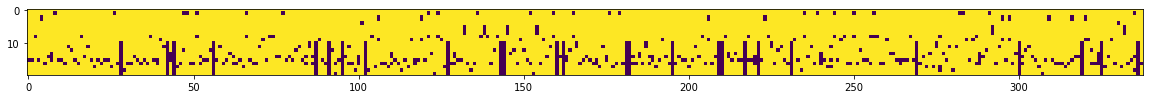

In [34]:
featmat = np.vstack(totalmasks).T
plt.figure(figsize=(20,20))
plt.imshow(featmat)
plt.show()

In [7]:
def featmat2phylip(mat, IDs= None, filename='phylmat.txt'):
    #each row is binary features for sequences
    with open(filename,'w') as phylout:
        phylout.write(str(mat.shape[0]) +' ' + str(mat.shape[1]) +'\n')
        for l in range(mat.shape[0]):
            if IDs is not None:
                outstr = IDs[l].split('_')[-1] +' ' +''.join([ str(b) for b in list(mat[l,:])])  +'\n'
            else:
                outstr = str(l)+ ' ' +''.join([ str(b) for b in list(mat[l,:])]) +'\n'
            phylout.write(outstr)


In [41]:
featmat2phylip(featmat , ids)

In [38]:
#run iqtree on binary and on dna

import shlex
from subprocess import Popen

def loadmodules():
    cmds = ['module load gcc' , 'module load ']
    Popen(cmd, shell = True)

def runFastTree(infile):
    outfile = infile+'.tree'
    cmd = 'VeryFastTree protein_alignment > ' + outfile
    cmd = shlex.split(cmd)
    return Popen(cmd)
   
def runiqtree(infile ,  binary = True):
    path = '/scratch/dmoi/software/iqtree-1.6.12-Linux/bin/'
    cmd = path + 'iqtree -i ' + 
    if binary == True:
        cmd += ' '
    else :
        cmd += ' '
    cmd = shlex.split(cmd)
    return Popen( )



SyntaxError: invalid syntax (<ipython-input-38-78957d62c4c8>, line 18)

In [39]:
nseqs = 20
niter = 10
alngen = yield_aln(alnfile)
seqgen = yield_seqs(alnfile)

for iteration in 
    sequences=[]
    for i in range(nseqs):
        #grab the aln lines
        sequences.append(next(alngen))
    #write to file
    SeqIO.write(sequences, str(iteration)+'.fasta', 'fasta')
    #run tree soft
    
    #run hash masks
    for k in range(nseqs):
        if i %10 ==0:
        print(i)
        seq = next(seqiter)
        hashvals = minhash_kmers( seq  , nperm = 2000 , windows = [25,35,45] )
        test_set.append( hashvals)
        test_set = np.vstack(test_set)
        


SyntaxError: invalid syntax (<ipython-input-39-ba3acc459c73>, line 6)

In [ ]:
#compare trees



In [ ]:
overwrite = True
nperm = 3000
row_count = 0
import pdb

batchsize = 10 * mp.cpu_count()
print(batchsize)

maxshape = (10000000, nperm)

if __name__ == '__main__':
    pool = mp.Pool()
    #kmer size mix for close and long range evolutionary distances
    def minhash_kmers( seq  , nperm = 10000 , windows = [25,30,35,40] ):
        #generate the minhash signature for each genome.
        h = datasketch.MinHash(num_perm = nperm  )
        [h.update(seq[position:position+window].encode('utf8')) for window in windows for position in range(0, len(seq) - window) ]
        return h.hashvalues

    def calc_chunk(seqiter, chunksize, pool ):
        seqs = []
        for i in range(chunksize):
            try:
                seqs.append(next(seqiter))
            except:
                pass
        res = np.vstack( pool.map( minhash_kmers , seqs) )
        return res

    if os.path.exists(alnfile+'_30'+'_hashes.h5') and overwrite == False:
        pass
    else:
        try:
            os.remove(alnfile +'hashes.h5')
        except:
            print('err delfile')
        print('hashes 2 hdf5 ')
        with h5py.File(alnfile +'hashes.h5', 'w' ) as f:
            dset = f.create_dataset('hashtable', shape=(0,nperm), maxshape=maxshape, chunks=(batchsize,nperm), dtype=np.int32 )
            seqiter = yield_seqs(alnfile)
            start = False
            count = 0
            while  start == False or chunk.shape[0]> 0:
                start = True
                chunk = calc_chunk( seqiter , batchsize , pool )                
                start = dset.shape[0]
                dset.resize(dset.shape[0] + chunk.shape[0], axis=0)
                dset[start:start+chunk.shape[0] ] = chunk   
                print(dset.shape)
        print('done')


480
hashes 2 hdf5 
(480, 3000)
(960, 3000)
(1440, 3000)
(1920, 3000)
(2400, 3000)
(2880, 3000)
(3360, 3000)
(3840, 3000)
(4320, 3000)
(4800, 3000)
(5280, 3000)
(5760, 3000)
(6240, 3000)
(6720, 3000)
(7200, 3000)
(7680, 3000)
(8160, 3000)
(8640, 3000)
(9120, 3000)
(9600, 3000)
(10080, 3000)
(10560, 3000)
(11040, 3000)
(11520, 3000)
(12000, 3000)
(12480, 3000)
(12960, 3000)
(13440, 3000)
(13920, 3000)
(14400, 3000)
(14880, 3000)
(15360, 3000)
(15840, 3000)
(16320, 3000)
(16800, 3000)
(17280, 3000)
(17760, 3000)
(18240, 3000)
(18720, 3000)
(19200, 3000)
(19680, 3000)
(20160, 3000)
(20640, 3000)
(21120, 3000)
(21600, 3000)
(22080, 3000)
(22560, 3000)
(23040, 3000)
(23520, 3000)
(24000, 3000)
(24480, 3000)
(24960, 3000)
(25440, 3000)
(25920, 3000)
(26400, 3000)
(26880, 3000)
(27360, 3000)
(27840, 3000)
(28320, 3000)
(28800, 3000)
(29280, 3000)
(29760, 3000)
(30240, 3000)
(30720, 3000)
(31200, 3000)
(31680, 3000)
(32160, 3000)
(32640, 3000)
(33120, 3000)
(33600, 3000)
(34080, 3000)
(34560, 3

In [ ]:


#stab at an NJ algo

#instead of pairwise use a 3rd as outgroup to generate the most likely
#if larger than pairwise just use subtree


def consensus(subtree,alnarray,consensusarray):
    #calc consensus sequence from subtree nodes
    index = [ rowIndex[l.name] for l in subtree.leaves()]
    #some algo to find a consensus sequence here
    
    """
    
    To obtain the consensus, the sequence weights and a scoring matrix are used to 
    calculate a score at each position in the alignment as follows. The residue (or nucleotide
    ) i in an alignment column, is compared to all other residues 
    (j) in the same column. The score for i is the sum over all residues j (not i=j) 
    of the score(ij)*weight(j), where score(ij) is taken from a nucleotide or protein scoring 
    matrix (see -datafile qualifier) and the "weight(j)" is the weighting given to the sequence j,
    which is given in the alignment file.

    The highest scoring type of residue is then found in the column. If the number of "positive matches"
    (see below) for this residue is greater than the "plurality value" (see below), then this residue 
    is the consensus residue. Otherwise there is no consensus for that position and an 'n' 
    (nucleotide sequence alignment) or an 'x' (protein sequence alignment) character is written to 
    the consensus sequence.
    
    """
    seq= b''
    submat = alnarray[index,:]
    for col in submat.shape[1]:
        symbols, counts = np.unique(submat[:,col] return_counts = True)
        #select largest and append
        seq+= 
        
    return consensusID , consensusSeq

def storeconsensus(storage, consensusID , consensusSeq):
    #generate a fasta of the consensus sequences at each step
    storage[consensusID] = consensusSeq

def delconsensus( storage, forest , consensusID  ):
    #you only need the nodes within the current round
    #no use storing the consensus seqs if you dont have the mem
    del storage[consensusID]
    remove_lsh_treenode(consensusID, forest)
    
def lsh_query( treenode , hashvals, lshforest, k = 3 ):
    #find the closest nodes
    return lshforest.query( hashvals[rowindex[treenode],:] )


def branchlen(n1,n2, hashvals , nperm):
    h1=datasketch.MinHash( nperm = , hashvalues = hashvalues)
    h2=datasketch.MinHash( nperm = , hashvalues = hashvalues)
    return h1.jaccard(h2)
    
def add_hash(hasvals, forest , rowIndex ):
    
    
    
def remove_lsh_treenode(key, forest):
        '''
        Remove the key from the index.

        Args:
            key (hashable): The unique identifier of a set.

        '''
        
        if key not in forest.keys:
            raise ValueError("The given key does not exist")
        for H, hashtable in zip(self.keys[key], forest.hashtables):
            hashtable.remove_val(H, key)
            if not hashtable.get(H):
                hashtable.remove(H)
        forest.keys.remove(key)


def add_treenode ()
#find closest node

#generate 
def 

In [ ]:
#get label for each seq
parsed = SeqIO.parse(alnfile, 'fasta')
seq2row = { seq.id:i for i,seq in enumerate(parsed) }
row2seq = dict(zip ( seq2row.values() , seq2row.keys() ) )

In [ ]:
import cProfile
import functools
import pstats
import tempfile
def profile_me(func):
    @functools.wraps(func)
    def wraps(*args, **kwargs):
        file = tempfile.mktemp()
        profiler = cProfile.Profile()
        profiler.runcall(func, *args, **kwargs)
        profiler.dump_stats(file)
        metrics = pstats.Stats(file)
        metrics.strip_dirs().sort_stats('time').print_stats(100)
    return wraps

In [14]:

#mker higher than the min in may have been in signatures with a lower value in this column...



In [15]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


In [10]:
from __future__ import division
import sys
import warnings
import pickle

minvals = 1
create_masks = True

#each col is a mask 
branch_count = 0
allcounts = []
minvalcounts = []
masks={}

print(alnfile +'hashes.h5')

with h5py.File(alnfile +'hashes.h5', 'r' ) as f:
        ht = f['hashtable']
        num_tasks = ht.shape[1]

print('masks to generate' , num_tasks)
coliterator = yield_cols(alnfile +'hashes.h5')
totalmasks =[]
pool = mp.Pool()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, masks in enumerate(pool.imap_unordered( get_masks , coliterator), 1):
        totalmasks.append(masks)
        if i%1000 == 0:
            print('saving', len(totalmasks))
            with open('masks.pkl' , 'wb') as pklout:
                pklout.write(pickle.dumps(totalmasks))
        if i%1000 == 0:
            print('\rdone {0:%}'.format(i/num_tasks))
pool.close()
totalmasks = [m for m in totalmasks if m]
featmat = np.vstack(totalmasks)

In [12]:
featmat2phylip(featmat.T  , filename = 'bigphylmat.txt')

#filter trivial masks
totalmasks = [m for m in totalmasks if m]
with open('masks.pkl' , 'wb') as pklout:
    pklout.write(pickle.dumps(totalmasks))
    

In [9]:
print(featmat)

[[ 49025  28311 117730 ...  14743 218464  32456]
 [ 49025  28311 117730 ...  14743 218464  32456]
 [ 49025  28311 117730 ...  14743 218464  32456]
 ...
 [ 49025  28311 117730 ...  14743 218464  32456]
 [ 49025  28311 117730 ...  14743 218464  32456]
 [ 49025  28311 117730 ...  14743 218464  32456]]


In [17]:
import collections
mask_count = dict(collections.Counter(totalmasks))


(array([2731.,    0.,    0.,    0.,    0.,  124.,    0.,    0.,    0.,
           7.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

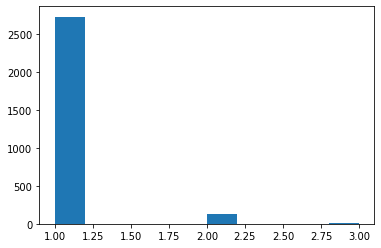

In [18]:
plt.hist(mask_count.values())

In [ ]:
cutoff = int(ht.shape[1] * frac)

masks = { m:masks[m]  for m in masks if masks[m] > cutoff}

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

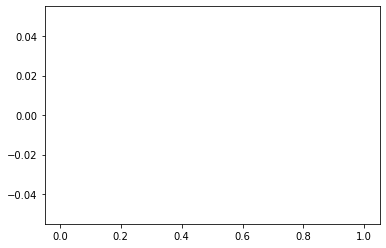

In [ ]:
tns = TaxonNamespace()
for i in range(r.shape[0]):
    tns.add_taxon(Taxon(seq_ids[i]))


t = Tree.from_split_bitmasks(splits, tns)
with open(f'{out_fn}.nwk', 'wt') as fp:
    print(t.as_string('newick', suppress_rooting=True, unquoted_underscores=True), file=fp)


In [4]:
# Copyright (C) 2013 by Yanbo Ye (yeyanbo289@gmail.com)
#
# This file is part of the Biopython distribution and governed by your
# choice of the "Biopython License Agreement" or the "BSD 3-Clause License".
# Please see the LICENSE file that should have been included as part of this
# package.

"""Classes and methods for finding consensus trees.
This module contains a ``_BitString`` class to assist the consensus tree
searching and some common consensus algorithms such as strict, majority rule and
adam consensus.
"""

import random
import itertools
import bitarray


from ast import literal_eval
from Bio.Phylo import BaseTree


class _BitString(str):
    """Helper class for binary string data (PRIVATE).
    Assistant class of binary string data used for storing and
    counting compatible clades in consensus tree searching. It includes
    some binary manipulation(&|^~) methods.
    _BitString is a sub-class of ``str`` object that only accepts two
    characters('0' and '1'), with additional functions for binary-like
    manipulation(&|^~). It is used to count and store the clades in
    multiple trees in consensus tree searching. During counting, the
    clades will be considered the same if their terminals(in terms of
    ``name`` attribute) are the same.
    For example, let's say two trees are provided as below to search
    their strict consensus tree::
        tree1: (((A, B), C),(D, E))
        tree2: ((A, (B, C)),(D, E))
    For both trees, a _BitString object '11111' will represent their
    root clade. Each '1' stands for the terminal clade in the list
    [A, B, C, D, E](the order might not be the same, it's determined
    by the ``get_terminal`` method of the first tree provided). For
    the clade ((A, B), C) in tree1 and (A, (B, C)) in tree2, they both
    can be represented by '11100'. Similarly, '11000' represents clade
    (A, B) in tree1, '01100' represents clade (B, C) in tree2, and '00011'
    represents clade (D, E) in both trees.
    So, with the ``_count_clades`` function in this module, finally we
    can get the clade counts and their _BitString representation as follows
    (the root and terminals are omitted)::
        clade   _BitString   count
        ABC     '11100'     2
        DE      '00011'     2
        AB      '11000'     1
        BC      '01100'     1
    To get the _BitString representation of a clade, we can use the following
    code snippet::
        # suppose we are provided with a tree list, the first thing to do is
        # to get all the terminal names in the first tree
        term_names = [term.name for term in trees[0].get_terminals()]
        # for a specific clade in any of the tree, also get its terminal names
        clade_term_names = [term.name for term in clade.get_terminals()]
        # then create a boolean list
        boolvals = [name in clade_term_names for name in term_names]
        # create the string version and pass it to _BitString
        bitstr = _BitString(''.join(map(str, map(int, boolvals))))
        # or, equivalently:
        bitstr = _BitString.from_bool(boolvals)
    To convert back::
        # get all the terminal clades of the first tree
        terms = [term for term in trees[0].get_terminals()]
        # get the index of terminal clades in bitstr
        index_list = bitstr.index_one()
        # get all terminal clades by index
        clade_terms = [terms[i] for i in index_list]
        # create a new calde and append all the terminal clades
        new_clade = BaseTree.Clade()
        new_clade.clades.extend(clade_terms)
    Examples
    --------
    >>> from Bio.Phylo.Consensus import _BitString
    >>> bitstr1 = _BitString('11111')
    >>> bitstr2 = _BitString('11100')
    >>> bitstr3 = _BitString('01101')
    >>> bitstr1
    _BitString('11111')
    >>> bitstr2 & bitstr3
    _BitString('01100')
    >>> bitstr2 | bitstr3
    _BitString('11101')
    >>> bitstr2 ^ bitstr3
    _BitString('10001')
    >>> bitstr2.index_one()
    [0, 1, 2]
    >>> bitstr3.index_one()
    [1, 2, 4]
    >>> bitstr3.index_zero()
    [0, 3]
    >>> bitstr1.contains(bitstr2)
    True
    >>> bitstr2.contains(bitstr3)
    False
    >>> bitstr2.independent(bitstr3)
    False
    >>> bitstr1.iscompatible(bitstr2)
    True
    >>> bitstr2.iscompatible(bitstr3)
    False
    """

    
    #todo: replace the .to01() by nice bitwise operations
    def __init__(self,strdata):

        """Init from a binary string data."""
        if isinstance(strdata, str):
            self.fixed_len = len(strdata)
            self.pad = bitarray.bitarray(self.fixed_len)
            self.bitarray = bitarray.bitarray(strdata)
        else:
            raise TypeError(
                "The input should be a binary string composed of '0' and '1'"
            )
        

    def __and__(self, other):
        result = self.bitarray & other.bitarray
        return result & self.pad
    
    def __or__(self, other):
        result = self.bitarray | other.bitarray
        return self.pad&result

    def __xor__(self, other):
        resultint = self.selfint ^ other.bitarray
        return self.pad&result

    def __rand__(self, other):
        result = self.bitarray & other.bitarray
        return pad&result

    def __ror__(self, other):
        result = self.bitarray | other.bitarray
        return self.pad&result

    
    def __rxor__(self, other):
        resultint = self.bitarray ^ other.bitarray
        return self.pad&result


    def __repr__(self):
        return "_BitString(" + self.to01() + ")"

    def index_one(self):
        """Return a list of positions where the element is '1'."""
        return [i for i, n in enumerate(self.bitarray.to01()) if n == "1"]

    def index_zero(self):
        """Return a list of positions where the element is '0'."""
        return [i for i, n in enumerate(self.bitarray.to01()) if n == "0"]

    def contains(self, other):
        """Check if current bitstr1 contains another one bitstr2.
        That is to say, the bitstr2.index_one() is a subset of
        bitstr1.index_one().
        Examples:
            "011011" contains "011000", "011001", "000011"
        Be careful, "011011" also contains "000000". Actually, all _BitString
        objects contain all-zero _BitString of the same length.
        """
        return -1<self.bitarray.find(other.bitarray, start=0, stop= self.fixed_len)
    
    def independent(self, other):
        """Check if current bitstr1 is independent of another one bitstr2.
        That is to say the bitstr1.index_one() and bitstr2.index_one() have
        no intersection.
        Be careful, all _BitString objects are independent of all-zero _BitString
        of the same length.
        """
        xorbit = self ^ other
        return xorbit.bitarray.to01().count("1") == self.bitarray.to01().count("1") + other.bitarray.to01().count("1")

    def iscompatible(self, other):
        """Check if current bitstr1 is compatible with another bitstr2.
        Two conditions are considered as compatible:
         1. bitstr1.contain(bitstr2) or vise versa;
         2. bitstr1.independent(bitstr2).
        """
        return self.contains(other) or other.contains(self) or self.independent(other)

    @classmethod
    def from_bool(cls, bools):
        return cls(bools)

#### end of bit helper stuff ###

In [6]:
def majority_consensus(trees, cutoff=0):
    """Search majority rule consensus tree from multiple trees.
    This is a extend majority rule method, which means the you can set any
    cutoff between 0 ~ 1 instead of 0.5. The default value of cutoff is 0 to
    create a relaxed binary consensus tree in any condition (as long as one of
    the provided trees is a binary tree). The branch length of each consensus
    clade in the result consensus tree is the average length of all counts for
    that clade.
    :Parameters:
        trees : iterable
            iterable of trees to produce consensus tree.
    """
    tree_iter = iter(trees)
    first_tree = next(tree_iter)

    terms = first_tree.get_terminals()
    bitstr_counts, tree_count = _count_clades(itertools.chain([first_tree], tree_iter))

    # Sort bitstrs by descending #occurrences, then #tips, then tip order
    bitstrs = sorted(
        bitstr_counts.keys(),
        key=lambda bitstr: (bitstr_counts[bitstr][0], bitstr.count("1"), str(bitstr)),
        reverse=True,
    )
    root = BaseTree.Clade()
    if bitstrs[0].count("1") == len(terms):
        root.clades.extend(terms)
    else:
        raise ValueError("Taxons in provided trees should be consistent")
    # Make a bitstr-to-clades dict and store root clade
    bitstr_clades = {bitstrs[0]: root}
    # create inner clades
    for bitstr in bitstrs[1:]:
        # apply majority rule
        count_in_trees, branch_length_sum = bitstr_counts[bitstr]
        confidence = 100.0 * count_in_trees / tree_count
        if confidence < cutoff * 100.0:
            break
        clade_terms = [terms[i] for i in bitstr.index_one()]
        clade = BaseTree.Clade()
        clade.clades.extend(clade_terms)
        clade.confidence = confidence
        clade.branch_length = branch_length_sum / count_in_trees
        bsckeys = sorted(bitstr_clades, key=lambda bs: bs.count("1"), reverse=True)

        # check if current clade is compatible with previous clades and
        # record its possible parent and child clades.
        compatible = True
        parent_bitstr = None
        child_bitstrs = []  # multiple independent childs
        for bs in bsckeys:
            if not bs.iscompatible(bitstr):
                compatible = False
                break
            # assign the closest ancestor as its parent
            # as bsckeys is sorted, it should be the last one
            if bs.contains(bitstr):
                parent_bitstr = bs
            # assign the closest descendant as its child
            # the largest and independent clades
            if (
                bitstr.contains(bs)
                and bs != bitstr
                and all(c.independent(bs) for c in child_bitstrs)
            ):
                child_bitstrs.append(bs)
        if not compatible:
            continue

        if parent_bitstr:
            # insert current clade; remove old bitstring
            parent_clade = bitstr_clades.pop(parent_bitstr)
            # update parent clade childs
            parent_clade.clades = [
                c for c in parent_clade.clades if c not in clade_terms
            ]
            # set current clade as child of parent_clade
            parent_clade.clades.append(clade)
            # update bitstring
            # parent = parent ^ bitstr
            # update clade
            bitstr_clades[parent_bitstr] = parent_clade

        if child_bitstrs:
            remove_list = []
            for c in child_bitstrs:
                remove_list.extend(c.index_one())
                child_clade = bitstr_clades[c]
                parent_clade.clades.remove(child_clade)
                clade.clades.append(child_clade)
            remove_terms = [terms[i] for i in remove_list]
            clade.clades = [c for c in clade.clades if c not in remove_terms]
        # put new clade
        bitstr_clades[bitstr] = clade
        if (len(bitstr_clades) == len(terms) - 1) or (
            len(bitstr_clades) == len(terms) - 2 and len(root.clades) == 3
        ):
            break
    return BaseTree.Tree(root=root)


def adam_consensus(trees):
    """Search Adam Consensus tree from multiple trees.
    :Parameters:
        trees : list
            list of trees to produce consensus tree.
    """
    clades = [tree.root for tree in trees]
    return BaseTree.Tree(root=_part(clades), rooted=True)


def _part(clades):
    """Recursive function for Adam Consensus algorithm (PRIVATE)."""
    new_clade = None
    terms = clades[0].get_terminals()
    term_names = [term.name for term in terms]
    if len(terms) == 1 or len(terms) == 2:
        new_clade = clades[0]
    else:
        bitstrs = {_BitString("1" * len(terms))}
        for clade in clades:
            for child in clade.clades:
                bitstr = _clade_to_bitstr(child, term_names)
                to_remove = set()
                to_add = set()
                for bs in bitstrs:
                    if bs == bitstr:
                        continue
                    elif bs.contains(bitstr):
                        to_add.add(bitstr)
                        to_add.add(bs ^ bitstr)
                        to_remove.add(bs)
                    elif bitstr.contains(bs):
                        to_add.add(bs ^ bitstr)
                    elif not bs.independent(bitstr):
                        to_add.add(bs & bitstr)
                        to_add.add(bs & bitstr ^ bitstr)
                        to_add.add(bs & bitstr ^ bs)
                        to_remove.add(bs)
                # bitstrs = bitstrs | to_add
                bitstrs ^= to_remove
                if to_add:
                    for ta in sorted(to_add, key=lambda bs: bs.count("1")):
                        independent = True
                        for bs in bitstrs:
                            if not ta.independent(bs):
                                independent = False
                                break
                        if independent:
                            bitstrs.add(ta)
        new_clade = BaseTree.Clade()
        for bitstr in sorted(bitstrs):
            indices = bitstr.index_one()
            if len(indices) == 1:
                new_clade.clades.append(terms[indices[0]])
            elif len(indices) == 2:
                bifur_clade = BaseTree.Clade()
                bifur_clade.clades.append(terms[indices[0]])
                bifur_clade.clades.append(terms[indices[1]])
                new_clade.clades.append(bifur_clade)
            elif len(indices) > 2:
                part_names = [term_names[i] for i in indices]
                next_clades = []
                for clade in clades:
                    next_clades.append(_sub_clade(clade, part_names))
                # next_clades = [clade.common_ancestor([clade.find_any(name=name) for name in part_names]) for clade in clades]
                new_clade.clades.append(_part(next_clades))
    return new_clade


def _sub_clade(clade, term_names):
    """Extract a compatible subclade that only contains the given terminal names (PRIVATE)."""
    term_clades = [clade.find_any(name) for name in term_names]
    sub_clade = clade.common_ancestor(term_clades)
    if len(term_names) != sub_clade.count_terminals():
        temp_clade = BaseTree.Clade()
        temp_clade.clades.extend(term_clades)
        for c in sub_clade.find_clades(terminal=False, order="preorder"):
            if c == sub_clade.root:
                continue
            childs = set(c.find_clades(terminal=True)) & set(term_clades)
            if childs:
                for tc in temp_clade.find_clades(terminal=False, order="preorder"):
                    tc_childs = set(tc.clades)
                    tc_new_clades = tc_childs - childs
                    if childs.issubset(tc_childs) and tc_new_clades:
                        tc.clades = list(tc_new_clades)
                        child_clade = BaseTree.Clade()
                        child_clade.clades.extend(list(childs))
                        tc.clades.append(child_clade)
        sub_clade = temp_clade
    return sub_clade


def _count_clades(trees):
    """Count distinct clades (different sets of terminal names) in the trees (PRIVATE).
    Return a tuple first a dict of bitstring (representing clade) and a tuple of its count of
    occurrences and sum of branch length for that clade, second the number of trees processed.
    :Parameters:
        trees : iterable
            An iterable that returns the trees to count
    """
    bitstrs = {}
    tree_count = 0
    for tree in trees:
        tree_count += 1
        clade_bitstrs = _tree_to_bitstrs(tree)
        for clade in tree.find_clades(terminal=False):
            bitstr = clade_bitstrs[clade]
            if bitstr in bitstrs:
                count, sum_bl = bitstrs[bitstr]
                count += 1
                sum_bl += clade.branch_length or 0
                bitstrs[bitstr] = (count, sum_bl)
            else:
                bitstrs[bitstr] = (1, clade.branch_length or 0)
    return bitstrs, tree_count


def get_support(target_tree, trees, len_trees=None):
    """Calculate branch support for a target tree given bootstrap replicate trees.
    :Parameters:
        target_tree : Tree
            tree to calculate branch support for.
        trees : iterable
            iterable of trees used to calculate branch support.
        len_trees : int
            optional count of replicates in trees. len_trees must be provided
            when len(trees) is not a valid operation.
    """
    term_names = sorted(term.name for term in target_tree.find_clades(terminal=True))
    bitstrs = {}

    size = len_trees
    if size is None:
        try:
            size = len(trees)
        except TypeError:
            raise TypeError(
                "Trees does not support len(trees), "
                "you must provide the number of replicates in trees "
                "as the optional parameter len_trees."
            ) from None

    for clade in target_tree.find_clades(terminal=False):
        bitstr = _clade_to_bitstr(clade, term_names)
        bitstrs[bitstr] = (clade, 0)
    for tree in trees:
        for clade in tree.find_clades(terminal=False):
            bitstr = _clade_to_bitstr(clade, term_names)
            if bitstr in bitstrs:
                c, t = bitstrs[bitstr]
                c.confidence = (t + 1) * 100.0 / size
                bitstrs[bitstr] = (c, t + 1)
    return target_tree


def bootstrap(msa, times):
    """Generate bootstrap replicates from a multiple sequence alignment object.
    :Parameters:
        msa : MultipleSeqAlignment
            multiple sequence alignment to generate replicates.
        times : int
            number of bootstrap times.
    """
    length = len(msa[0])
    i = 0
    while i < times:
        i += 1
        item = None
        for j in range(length):
            col = random.randint(0, length - 1)
            if not item:
                item = msa[:, col : col + 1]
            else:
                item += msa[:, col : col + 1]
        yield item


def bootstrap_trees(msa, times, tree_constructor):
    """Generate bootstrap replicate trees from a multiple sequence alignment.
    :Parameters:
        msa : MultipleSeqAlignment
            multiple sequence alignment to generate replicates.
        times : int
            number of bootstrap times.
        tree_constructor : TreeConstructor
            tree constructor to be used to build trees.
    """
    msas = bootstrap(msa, times)
    for aln in msas:
        tree = tree_constructor.build_tree(aln)
        yield tree


def bootstrap_consensus(msa, times, tree_constructor, consensus):
    """Consensus tree of a series of bootstrap trees for a multiple sequence alignment.
    :Parameters:
        msa : MultipleSeqAlignment
            Multiple sequence alignment to generate replicates.
        times : int
            Number of bootstrap times.
        tree_constructor : TreeConstructor
            Tree constructor to be used to build trees.
        consensus : function
            Consensus method in this module: ``strict_consensus``,
            ``majority_consensus``, ``adam_consensus``.
    """
    trees = bootstrap_trees(msa, times, tree_constructor)
    tree = consensus(list(trees))
    return tree


def _clade_to_bitstr(clade, tree_term_names):
    """Create a BitString representing a clade, given ordered tree taxon names (PRIVATE)."""
    clade_term_names = {term.name for term in clade.find_clades(terminal=True)}
    return _BitString.from_bool((name in clade_term_names) for name in tree_term_names)


def _tree_to_bitstrs(tree):
    """Create a dict of a tree's clades to corresponding BitStrings (PRIVATE)."""
    clades_bitstrs = {}
    term_names = [term.name for term in tree.find_clades(terminal=True)]
    for clade in tree.find_clades(terminal=False):
        bitstr = _clade_to_bitstr(clade, term_names)
        clades_bitstrs[clade] = bitstr
    return clades_bitstrs


def _bitstring_topology(tree):
    """Generate a branch length dict for a tree, keyed by BitStrings (PRIVATE).
    Create a dict of all clades' BitStrings to the corresponding branch
    lengths (rounded to 5 decimal places).
    """
    bitstrs = {}
    for clade, bitstr in _tree_to_bitstrs(tree).items():
        bitstrs[bitstr] = round(clade.branch_length or 0.0, 5)
    return bitstrs


def _equal_topology(tree1, tree2):
    """Are two trees are equal in terms of topology and branch lengths (PRIVATE).
    (Branch lengths checked to 5 decimal places.)
    """
    term_names1 = {term.name for term in tree1.find_clades(terminal=True)}
    term_names2 = {term.name for term in tree2.find_clades(terminal=True)}
    return (term_names1 == term_names2) and (
        _bitstring_topology(tree1) == _bitstring_topology(tree2)
    )